#### Imports and Setup

In [1]:
!pip uninstall umap -y
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

#### Set random seeds for reproducibility

In [3]:
torch.manual_seed(42)
np.random.seed(42)

#### Calculate the mean and standard deviation of the CIFAR-10 dataset

In [4]:
def calculate_mean_std():
    transform = transforms.Compose([transforms.ToTensor()])

    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    trainloader = DataLoader(
        trainset,
        batch_size=128,
        shuffle=False,
        num_workers=2
    )

    mean = torch.zeros(3)
    std = torch.zeros(3)

    print('==> Computing mean and std...')

    for images, _ in trainloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(trainset)

    for images, _ in trainloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        std += ((images - mean.unsqueeze(1))**2).mean(2).sum(0)
    std = torch.sqrt(std / len(trainset))

    return mean, std

In [5]:
mean, std = calculate_mean_std()

print('Mean:', mean.numpy())

print('Std:', std.numpy())

100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
==> Computing mean and std...
Mean: [0.49139962 0.4821585  0.44653094]
Std: [0.24703224 0.24348517 0.26158783]


#### Create training and testing transforms for CIFAR-10

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy()),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

 #### Load CIFAR-10 training and test datasets

In [7]:
full_trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


#### Convert image dataset to DataFrame for statistical analysis

In [8]:
def convert_dataset_to_df(dataset, num_samples=1000):
    """Convert image dataset to DataFrame for statistical analysis"""
    samples = []
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img_np = img.numpy()

        # Calculate statistics for each channel
        channel_stats = {
            'R_mean': img_np[0].mean(),
            'G_mean': img_np[1].mean(),
            'B_mean': img_np[2].mean(),
            'R_std': img_np[0].std(),
            'G_std': img_np[1].std(),
            'B_std': img_np[2].std(),
            'label': label
        }
        samples.append(channel_stats)

    return pd.DataFrame(samples)

#### Descriptive Statistics

In [9]:
def perform_descriptive_statistics(df):
    """Perform detailed statistical analysis on the dataset"""
    # 1. Basic Statistical Summary
    basic_stats = df.describe()
    print("\n## Basic Statistical Summary")
    print(basic_stats)

    # 2. Calculate additional statistics
    stats_dict = {
        'Mean': df.mean(),
        'Median': df.median(),
        'Mode': df.mode().iloc[0],
        'Standard Deviation': df.std(),
        'Variance': df.var(),
        'Skewness': df.skew(),
        'Kurtosis': df.kurtosis(),
        'Range': df.max() - df.min(),
        'IQR': df.quantile(0.75) - df.quantile(0.25)
    }

    detailed_stats = pd.DataFrame(stats_dict)
    print("\n## Detailed Statistics")
    print(detailed_stats)

    # 3. Visual Analysis - Boxplots
    plt.figure(figsize=(15, 5))
    for i, column in enumerate(['R_mean', 'G_mean', 'B_mean']):
        plt.subplot(1, 3, i+1)
        sns.boxplot(data=df[column])
        plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

    # 4. Distribution Analysis
    plt.figure(figsize=(15, 5))
    for i, column in enumerate(['R_mean', 'G_mean', 'B_mean']):
        plt.subplot(1, 3, i+1)
        sns.histplot(data=df, x=column, kde=True)
        plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

    # 5. Missing Values Analysis
    missing_values = df.isnull().sum()
    print("\n## Missing Values")
    print(missing_values)

    # 6. Correlation Analysis
    correlation = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [10]:
def analyze_dataset_statistics(dataset, name="Dataset"):
    print(f"\n=== Statistical Analysis for {name} ===")

    # Convert dataset to DataFrame
    df = convert_dataset_to_df(dataset)

    # Perform descriptive statistics
    perform_descriptive_statistics(df)

    # Additional analysis specific to image data
    print("\n## Class Distribution")
    class_dist = df['label'].value_counts().sort_index()

    # Print class distribution along with the label names
    print("Class distribution (label names):")
    for label, count in class_dist.items():
        print(f"Label: {label}, Count: {count}")

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', order=class_dist.index)
    plt.title('Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate label names for better visibility
    plt.show()

    return df


=== Performing Statistical Analysis ===

=== Statistical Analysis for Training Set ===

## Basic Statistical Summary
            R_mean       G_mean       B_mean        R_std        G_std  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -0.029482    -0.025437    -0.021641     0.788412     0.785731   
std       0.434528     0.446320     0.513664     0.221434     0.223861   
min      -1.424983    -1.378789    -1.208791     0.270554     0.189243   
25%      -0.320143    -0.321214    -0.382433     0.631860     0.621425   
50%      -0.037836    -0.044167    -0.057518     0.784455     0.779289   
75%       0.253516     0.253800     0.272149     0.938577     0.934196   
max       1.509735     1.471624     1.784306     1.527486     1.524498   

             B_std        label  
count  1000.000000  1000.000000  
mean      0.750200     4.475000  
std       0.225005     2.918543  
min       0.171404     0.000000  
25%       0.576374     2.000000  
50%       0

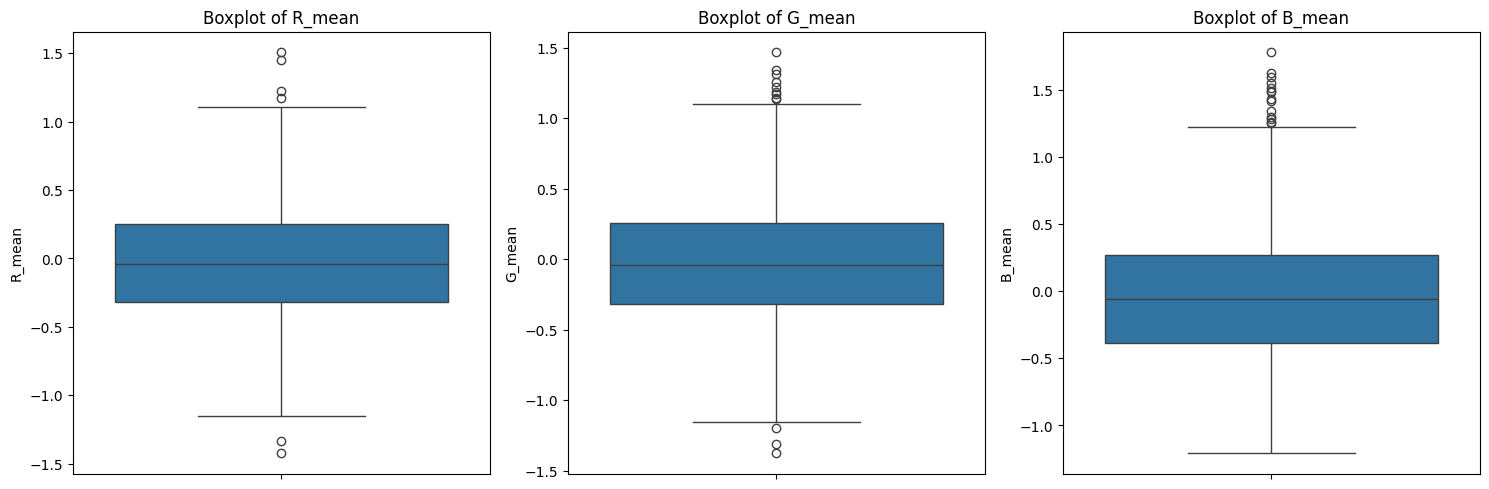

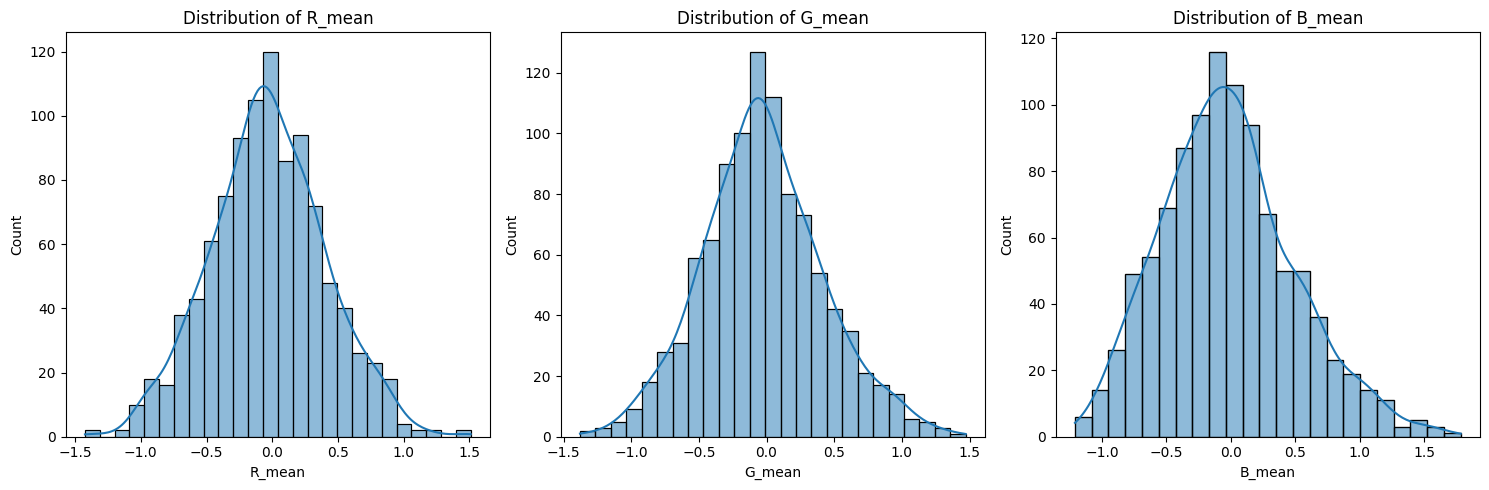


## Missing Values
R_mean    0
G_mean    0
B_mean    0
R_std     0
G_std     0
B_std     0
label     0
dtype: int64


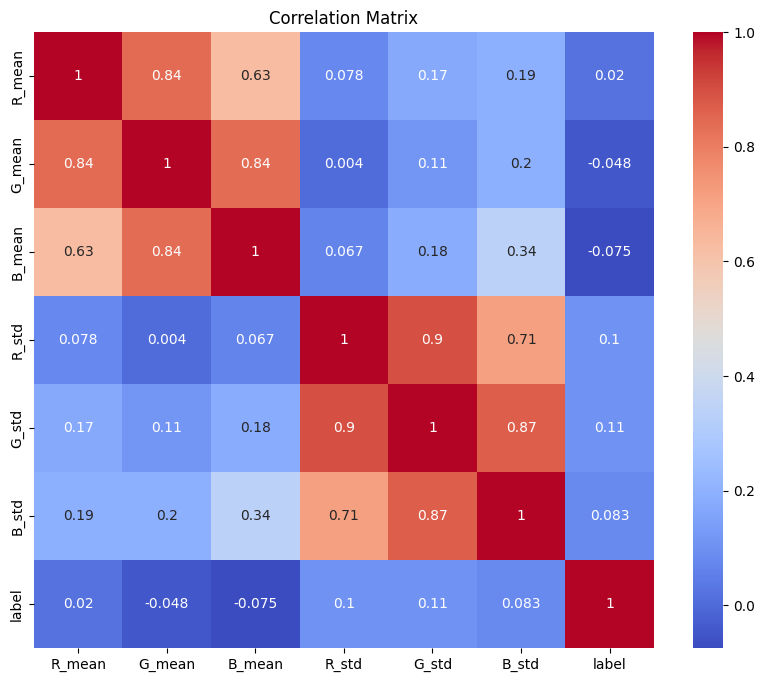


## Class Distribution
Class distribution (label names):
Label: 0, Count: 113
Label: 1, Count: 104
Label: 2, Count: 91
Label: 3, Count: 94
Label: 4, Count: 94
Label: 5, Count: 97
Label: 6, Count: 101
Label: 7, Count: 104
Label: 8, Count: 106
Label: 9, Count: 96


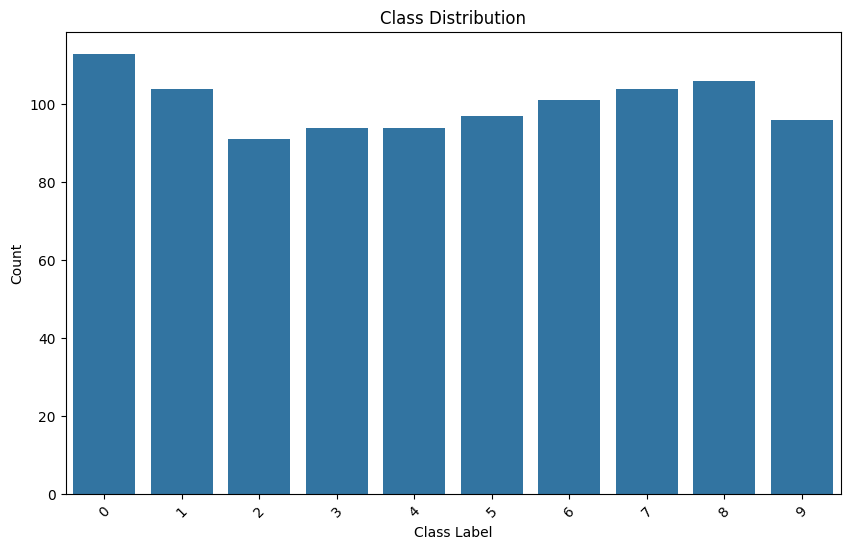

In [11]:
print("\n=== Performing Statistical Analysis ===")

# Analyze training set
train_df = analyze_dataset_statistics(full_trainset, "Training Set")

In [12]:
def visualize_class_examples(dataset, classes, samples_per_class=5):
    """Display random examples from each class"""
    fig, axes = plt.subplots(len(classes), samples_per_class,
                            figsize=(samples_per_class*2, len(classes)*2))

    class_indices = {i: [] for i in range(len(classes))}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    for i, class_name in enumerate(classes):
        class_samples = np.random.choice(class_indices[i], samples_per_class, replace=False)

        for j, idx in enumerate(class_samples):
            img, _ = dataset[idx]
            img = img.numpy().transpose(1, 2, 0)
            img = img * np.array(std) + np.array(mean)
            img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{class_name}', loc='left')

    plt.tight_layout()
    plt.show()

In [13]:
def apply_dimensionality_reduction(dataset, n_samples=1000, random_state=42):
    """Apply PCA, t-SNE, and UMAP"""
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    data = []
    labels = []

    for idx in indices:
        img, label = dataset[idx]
        data.append(img.numpy().flatten())
        labels.append(label)

    X = np.array(data)
    y = np.array(labels)

    pca = PCA(n_components=3, random_state=random_state)
    pca_result = pca.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_result = tsne.fit_transform(X)

    reducer = umap.UMAP(random_state=random_state)
    umap_result = reducer.fit_transform(X)

    return pca_result, tsne_result, umap_result, y

In [14]:
def plot_dimensionality_reduction(pca_result, tsne_result, umap_result, labels, classes):
    """Plot dimensionality reduction results"""
    fig = plt.figure(figsize=(20, 5))

    ax = fig.add_subplot(131, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                        c=labels, cmap='tab10')
    ax.set_title('PCA Visualization')
    plt.colorbar(scatter)

    ax = fig.add_subplot(132)
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1],
                        c=labels, cmap='tab10')
    ax.set_title('t-SNE Visualization')
    plt.colorbar(scatter)

    ax = fig.add_subplot(133)
    scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1],
                        c=labels, cmap='tab10')
    ax.set_title('UMAP Visualization')
    plt.colorbar(scatter)

    plt.tight_layout()
    plt.show()

In [15]:
# Perform visualizations
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')


=== Data Visualization ===


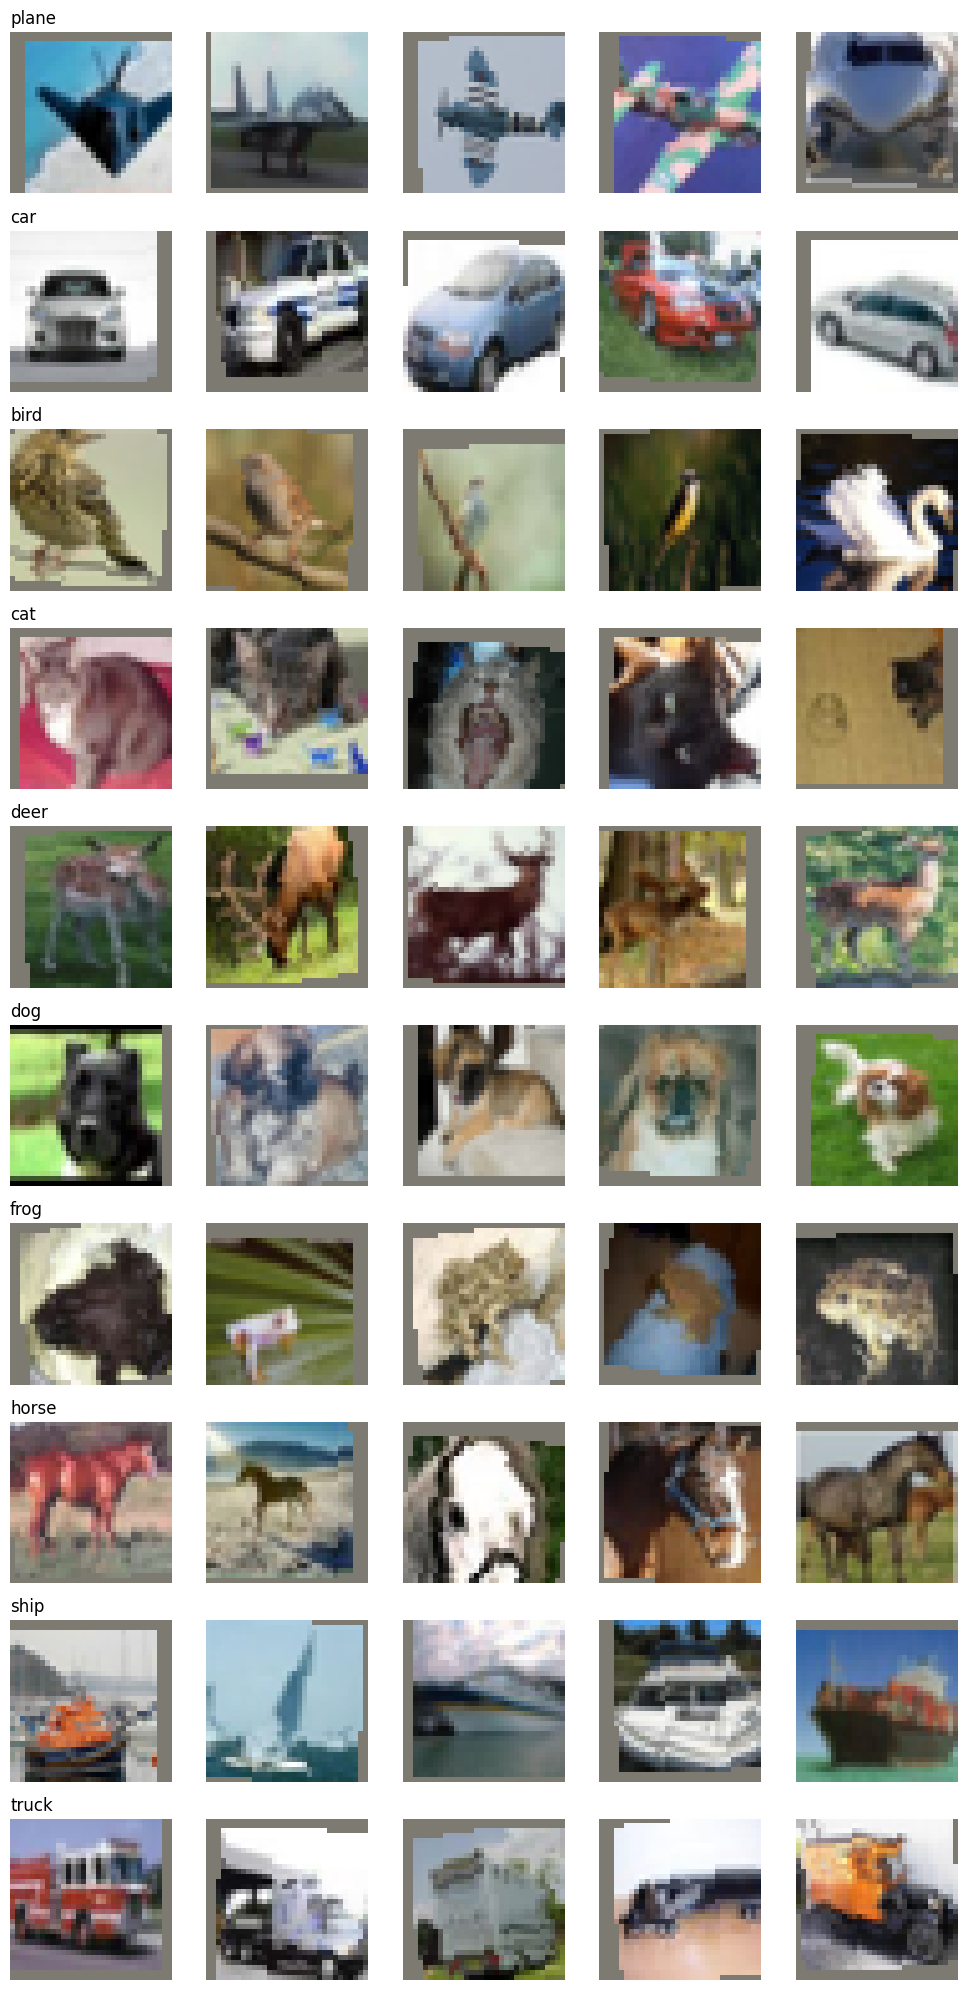

In [16]:
print("\n=== Data Visualization ===")
visualize_class_examples(full_trainset, classes)

Performing dimensionality reduction...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


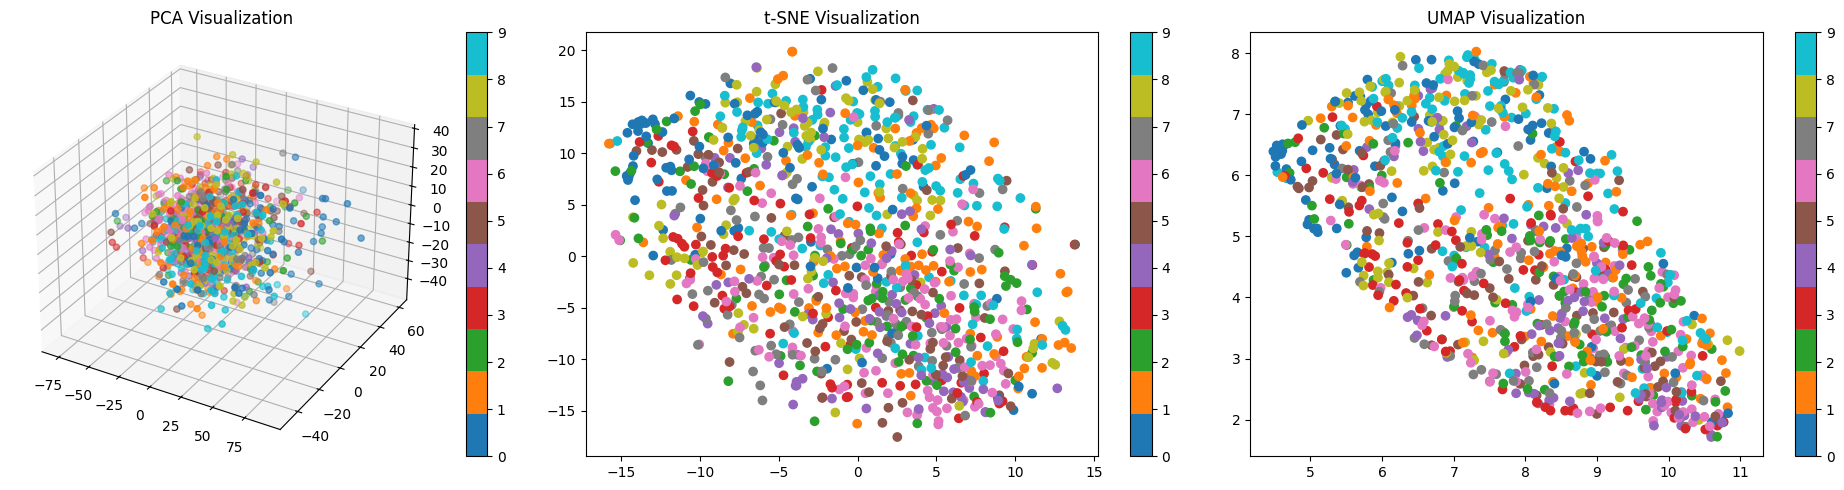

In [17]:
print("Performing dimensionality reduction...")
pca_result, tsne_result, umap_result, labels = apply_dimensionality_reduction(full_trainset)
plot_dimensionality_reduction(pca_result, tsne_result, umap_result, labels, classes)

#### Split training data into train and validation sets

In [18]:
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

total_size = len(full_trainset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

In [19]:
trainset, valset = random_split(
    full_trainset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

#### Create data loaders

In [20]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

#### Verify the splits

In [21]:
print(f'\nDataset sizes:')
print(f'Total training set size: {total_size}')
print(f'Training set size: {len(trainset)}')
print(f'Validation set size: {len(valset)}')
print(f'Test set size: {len(testset)}')

images, labels = next(iter(trainloader))
print(f'\nBatch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')


Dataset sizes:
Total training set size: 50000
Training set size: 40000
Validation set size: 10000
Test set size: 10000

Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [23]:

# Load and preprocess CIFAR-10 dataset using PyTorch
def load_cifar10(full_trainset, testset, num_train_images=None, num_test_images=None):

    train_dataset = full_trainset
    test_dataset = testset
    # Convert to numpy arrays
    train_images = train_dataset.data
    train_labels = np.array(train_dataset.targets)
    test_images = test_dataset.data
    test_labels = np.array(test_dataset.targets)

    # Reduce training dataset size if num_train_images is specified
    if num_train_images:
        train_images, _, train_labels, _ = train_test_split(
            train_images, train_labels, train_size=num_train_images, stratify=train_labels, random_state=42
        )

    # Reduce test dataset size if num_test_images is specified
    if num_test_images:
        test_images, _, test_labels, _ = train_test_split(
            test_images, test_labels, train_size=num_test_images, stratify=test_labels, random_state=42
        )

    # Flatten images and normalize to [0, 1]
    train_images = train_images.reshape(len(train_images), -1) / 255.0
    test_images = test_images.reshape(len(test_images), -1) / 255.0

    return train_images, train_labels, test_images, test_labels

# Load dataset
# num_train_images = 10000  # Modify this value for training dataset size
# num_test_images = 1000    # Modify this value for test dataset size
# X_train, y_train, X_test, y_test = load_cifar10(num_train_images=num_train_images, num_test_images=num_test_images)
X_train, y_train, X_test, y_test = load_cifar10(full_trainset, testset, num_train_images=None, num_test_images=None)
print(len(X_train), len(X_test))

50000 10000


# Logistic Regression

In [24]:
# Train a logistic regression model using scikit-learn
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=200,  # Adjust based on convergence
    verbose=1
)

print("Training Logistic Regression Model...")
model.fit(X_train, y_train)

Training Logistic Regression Model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


max_iter reached after 1246 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=200, multi_class='multinomial', solver='saga',
                   verbose=1)

In [25]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.46      0.49      0.47      1000
     Class 1       0.46      0.46      0.46      1000
     Class 2       0.31      0.28      0.30      1000
     Class 3       0.27      0.25      0.26      1000
     Class 4       0.34      0.29      0.31      1000
     Class 5       0.32      0.33      0.32      1000
     Class 6       0.41      0.46      0.43      1000
     Class 7       0.44      0.42      0.43      1000
     Class 8       0.49      0.53      0.51      1000
     Class 9       0.43      0.45      0.44      1000

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.39     10000
weighted avg       0.39      0.40      0.39     10000



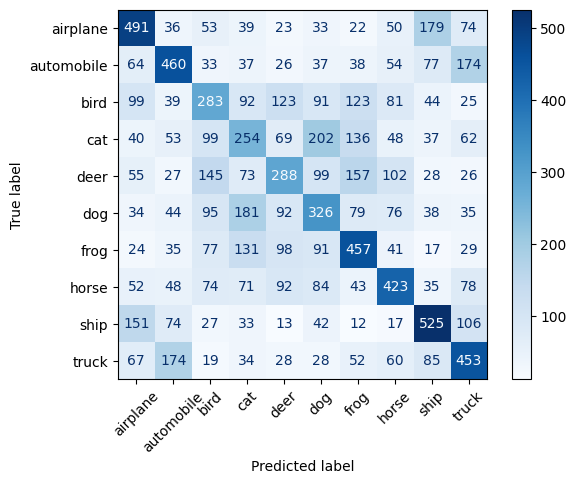

In [26]:
# Evaluate the model
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(10)]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

# Validation to find max depth

In [27]:
from sklearn.model_selection import cross_val_score

# Test different values for max_depth
for depth in range(5, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Max Depth: {depth}, Cross-Validation Accuracy: {scores.mean():.3f}")

Max Depth: 5, Cross-Validation Accuracy: 0.257
Max Depth: 6, Cross-Validation Accuracy: 0.272
Max Depth: 7, Cross-Validation Accuracy: 0.282
Max Depth: 8, Cross-Validation Accuracy: 0.292
Max Depth: 9, Cross-Validation Accuracy: 0.296
Max Depth: 10, Cross-Validation Accuracy: 0.295


# Decision Tree

In [28]:
apply_pca = False  # Set to False to skip PCA
if apply_pca:
    n_components = 100  # Number of principal components to keep
    print(f"Applying PCA to reduce dimensions to {n_components}...")
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=10, random_state=42)
print("Training Decision Tree Classifier...")
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Training Decision Tree Classifier...

Classification Report:
              precision    recall  f1-score   support

    airplane       0.38      0.43      0.41      1000
  automobile       0.35      0.29      0.32      1000
        bird       0.22      0.19      0.20      1000
         cat       0.17      0.18      0.18      1000
        deer       0.26      0.25      0.25      1000
         dog       0.28      0.22      0.25      1000
        frog       0.28      0.44      0.35      1000
       horse       0.31      0.28      0.29      1000
        ship       0.44      0.44      0.44      1000
       truck       0.36      0.35      0.35      1000

    accuracy                           0.31     10000
   macro avg       0.31      0.31      0.30     10000
weighted avg       0.31      0.31      0.30     10000



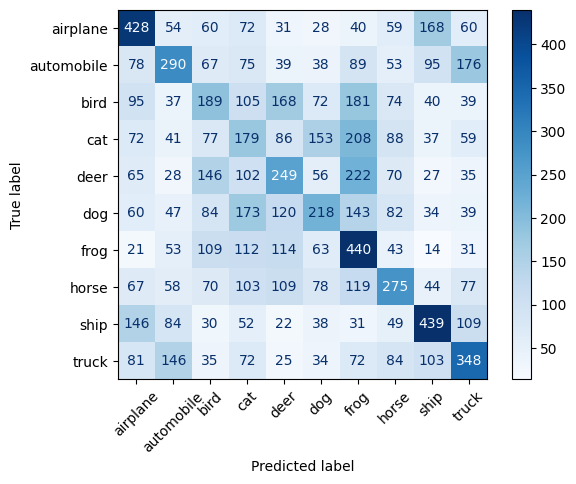

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

## Decision Tree with PCA

In [30]:
apply_pca = True  # Set to False to skip PCA
if apply_pca:
    n_components = 100  # Number of principal components to keep
    print(f"Applying PCA to reduce dimensions to {n_components}...")
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=10, random_state=42)
print("Training Decision Tree Classifier...")
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Applying PCA to reduce dimensions to 100...
Training Decision Tree Classifier...

Classification Report:
              precision    recall  f1-score   support

    airplane       0.39      0.49      0.43      1000
  automobile       0.36      0.35      0.35      1000
        bird       0.25      0.25      0.25      1000
         cat       0.19      0.19      0.19      1000
        deer       0.24      0.32      0.27      1000
         dog       0.30      0.21      0.24      1000
        frog       0.32      0.33      0.32      1000
       horse       0.33      0.21      0.26      1000
        ship       0.41      0.41      0.41      1000
       truck       0.36      0.38      0.37      1000

    accuracy                           0.31     10000
   macro avg       0.31      0.31      0.31     10000
weighted avg       0.31      0.31      0.31     10000



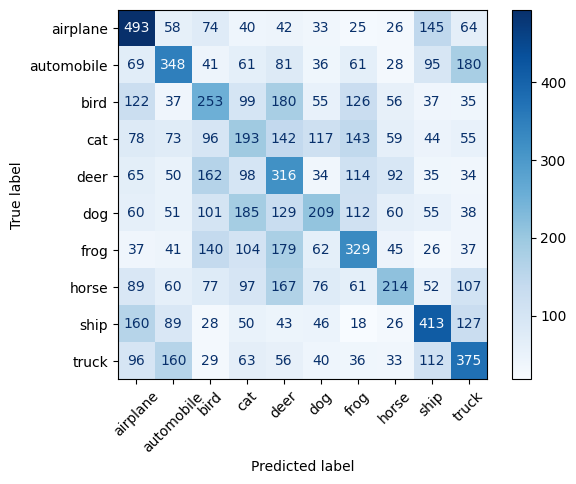

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()